In [ ]:
# Download the file from Google Drive
!gdown --id 1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn
From (redirected): https://drive.google.com/uc?id=1rI1H1q4szkxgyiOX6cFe5q9wXdOMZ-nn&confirm=t&uuid=228fedef-2df2-4ab9-9395-e7c3b15350f6
To: /content/workspace_updated.zip
100% 297M/297M [00:05<00:00, 58.6MB/s]


In [ ]:
!unzip /content/workspace_updated.zip

Archive:  /content/workspace_updated.zip
   creating: workspace/
  inflating: workspace/train_idx.npy  
  inflating: workspace/X_emb.npy     
  inflating: workspace/users_train.parquet  
  inflating: workspace/users.parquet  
  inflating: workspace/X_all.npy     
  inflating: workspace/test_idx.npy  
  inflating: workspace/users_test.parquet  
  inflating: workspace/X_all_train.npy  
  inflating: workspace/X_all_test.npy  


In [ ]:
# ======================================================================
# 02_hier_segments_anisha.ipynb
#
# Phase 3: Agglomerative / Hierarchical Clustering
#
# Goal:
#   - Use the shared workspace data (X_all, users, train/test indices)
#   - Run AgglomerativeClustering (Ward linkage) on a PCA-reduced
#     sample of the TRAIN data (for speed).
#   - Pick best number of clusters K using Silhouette score.
#   - Assign cluster labels to:
#       * TRAIN
#       * TEST
#       * ALL users (via nearest-centroid in PCA space).
#   - Save:
#       * hier_clusters_test.parquet  (user_id + hier_cluster for TEST)
#       * hier_clusters_all.parquet   (user_id + hier_cluster for ALL)
#
# This mirrors the KMeans and HDBSCAN notebooks in structure.
# ======================================================================

import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import NearestCentroid

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
sns.set()

WORKSPACE_DIR = Path("workspace")  # adjust if needed (e.g. "/content/project/workspace")

RANDOM_STATE = 42
MAX_SAMPLE_FOR_HIER = 3000   # number of train points used for hierarchical training
PCA_COMPONENTS = 25          # dimensionality reduction before Agglomerative
CANDIDATE_KS = [4, 6, 8]     # number of clusters to test

np.random.seed(RANDOM_STATE)

print("Workspace:", WORKSPACE_DIR.resolve())


Workspace: /content/workspace


In [ ]:
# --- Load shared Phase 3 data ---

X_all = np.load(WORKSPACE_DIR / "X_all.npy")          # (n_users, n_features)
users = pd.read_parquet(WORKSPACE_DIR / "users.parquet")  # must have 'user_id'

train_idx = np.load(WORKSPACE_DIR / "train_idx.npy")
test_idx  = np.load(WORKSPACE_DIR / "test_idx.npy")

print("Shapes:")
print("  X_all      :", X_all.shape)
print("  users      :", users.shape)
print("  train_idx  :", train_idx.shape)
print("  test_idx   :", test_idx.shape)

n_users = X_all.shape[0]
assert n_users == len(users), "X_all and users must have same number of rows."


Shapes:
  X_all      : (206207, 132)
  users      : (206207, 1)
  train_idx  : (164965,)
  test_idx   : (41242,)


In [ ]:
# --- Scale features and create train/test splits ---

scaler = StandardScaler().fit(X_all)
X_all_scaled = scaler.transform(X_all)

X_train = X_all_scaled[train_idx]
X_test  = X_all_scaled[test_idx]

users_train = users.iloc[train_idx].reset_index(drop=True)
users_test  = users.iloc[test_idx].reset_index(drop=True)

print("Scaled shapes:")
print("  X_train:", X_train.shape)
print("  X_test :", X_test.shape)
print("  users_train:", users_train.shape)
print("  users_test :", users_test.shape)


Scaled shapes:
  X_train: (164965, 132)
  X_test : (41242, 132)
  users_train: (164965, 1)
  users_test : (41242, 1)


In [ ]:
# --- Sample a subset of TRAIN for hierarchical clustering (for speed) ---

n_train = X_train.shape[0]
sample_size = min(MAX_SAMPLE_FOR_HIER, n_train)

rng = np.random.RandomState(RANDOM_STATE)
sample_idx = rng.choice(n_train, size=sample_size, replace=False)

X_train_sample = X_train[sample_idx]

print(f"Using a TRAIN sample of size {sample_size} out of {n_train} for hierarchical clustering.")


Using a TRAIN sample of size 3000 out of 164965 for hierarchical clustering.


In [ ]:
# --- PCA reduction before Agglomerative ---

pca_hier = PCA(n_components=PCA_COMPONENTS, random_state=RANDOM_STATE)

X_train_sample_pca = pca_hier.fit_transform(X_train_sample)
X_train_pca        = pca_hier.transform(X_train)
X_test_pca         = pca_hier.transform(X_test)
X_all_pca          = pca_hier.transform(X_all_scaled)

print("PCA shapes:")
print("  X_train_sample_pca:", X_train_sample_pca.shape)
print("  X_train_pca       :", X_train_pca.shape)
print("  X_test_pca        :", X_test_pca.shape)
print("  X_all_pca         :", X_all_pca.shape)


PCA shapes:
  X_train_sample_pca: (3000, 25)
  X_train_pca       : (164965, 25)
  X_test_pca        : (41242, 25)
  X_all_pca         : (206207, 25)


In [ ]:
# --- Try multiple cluster counts using Agglomerative on PCA(train_sample) ---

results = []

for k in CANDIDATE_KS:
    print(f"\nRunning AgglomerativeClustering with k={k} on train sample...")
    agg = AgglomerativeClustering(
        n_clusters=k,
        linkage="ward"
    )
    labels_sample = agg.fit_predict(X_train_sample_pca)

    sil = silhouette_score(X_train_sample_pca, labels_sample)
    db  = davies_bouldin_score(X_train_sample_pca, labels_sample)
    results.append((k, sil, db))

    print(f"k={k} | Silhouette={sil:.4f} | Davies–Bouldin={db:.4f}")

results_df = pd.DataFrame(results, columns=["n_clusters", "silhouette", "dbi"])
print("\nCandidate K results (train sample):")
display(results_df)



Running AgglomerativeClustering with k=4 on train sample...
k=4 | Silhouette=0.3689 | Davies–Bouldin=1.4037

Running AgglomerativeClustering with k=6 on train sample...
k=6 | Silhouette=0.2533 | Davies–Bouldin=1.7965

Running AgglomerativeClustering with k=8 on train sample...
k=8 | Silhouette=0.1260 | Davies–Bouldin=2.1410

Candidate K results (train sample):


,n_clusters,silhouette,dbi
0,4,0.368906,1.403661
1,6,0.253290,1.796484
2,8,0.126001,2.140959


In [ ]:
# --- Choose best k by highest Silhouette score ---

best_entry = max(results, key=lambda x: x[1])  # x[1] is silhouette
best_k, best_sil, best_dbi = best_entry

print("\nBest k based on Silhouette on train sample:")
print(f"  k = {best_k}")
print(f"  Silhouette = {best_sil:.4f}")
print(f"  DBI        = {best_dbi:.4f}")



Best k based on Silhouette on train sample:
  k = 4
  Silhouette = 0.3689
  DBI        = 1.4037


In [ ]:
# --- Fit final Agglomerative on train_sample_pca with best_k ---

print(f"\nFitting final AgglomerativeClustering with k={best_k} on train sample...")
agg_final = AgglomerativeClustering(
    n_clusters=best_k,
    linkage="ward"
)
labels_train_sample = agg_final.fit_predict(X_train_sample_pca)

# --- Compute centroids in PCA space using NearestCentroid ---
# We use NearestCentroid as a "cluster assignment" model: for any new point,
# it assigns the label of the nearest centroid in PCA space.

centroid_model = NearestCentroid()
centroid_model.fit(X_train_sample_pca, labels_train_sample)

# Assign clusters to ALL, TRAIN, and TEST users in PCA space
labels_all  = centroid_model.predict(X_all_pca)
labels_train = labels_all[train_idx]
labels_test  = labels_all[test_idx]

print("\nCluster counts (ALL USERS):")
cluster_counts_all = pd.Series(labels_all).value_counts().sort_index()
print(cluster_counts_all)



Fitting final AgglomerativeClustering with k=4 on train sample...

Cluster counts (ALL USERS):
0     66475
1     16968
2    117495
3      5269
Name: count, dtype: int64


In [ ]:
# --- Internal metrics (Silhouette, DBI) on TEST split ---

def cluster_metrics(X, labels, name=""):
    labels = np.asarray(labels)
    if len(np.unique(labels)) < 2:
        print(f"{name}: Not enough clusters for metrics.")
        return np.nan, np.nan

    sil = silhouette_score(X, labels)
    db  = davies_bouldin_score(X, labels)
    print(f"{name:10s} | Silhouette={sil:.4f} | DBI={db:.4f}")
    return sil, db

print("\n=== Internal metrics (TEST split, original scaled space) ===")
sil_test, db_test = cluster_metrics(X_test, labels_test, "Hierarchical")

metrics_df = pd.DataFrame(
    [{"model": "Hierarchical", "split": "TEST", "silhouette": sil_test, "dbi": db_test}]
)
display(metrics_df)



=== Internal metrics (TEST split, original scaled space) ===
Hierarchical | Silhouette=0.2956 | DBI=1.7102


,model,split,silhouette,dbi
0,Hierarchical,TEST,0.295595,1.710244


In [ ]:
# --- Attach labels to users and save parquet files ---

# All users
users_all = users.copy()
users_all["hier_cluster"] = labels_all

out_all = WORKSPACE_DIR / "hier_clusters_all.parquet"
users_all.to_parquet(out_all, index=False)
print(f"\nSaved ALL-USERS hierarchical clusters to: {out_all}")

# Train users (optional, for completeness)
users_train_out = users_all.iloc[train_idx].reset_index(drop=True)
out_train = WORKSPACE_DIR / "hier_clusters_train.parquet"
users_train_out.to_parquet(out_train, index=False)
print(f"Saved TRAIN hierarchical clusters to: {out_train}")

# Test users (this is the one used in comparison notebook)
users_test_out = users_all.iloc[test_idx].reset_index(drop=True)
out_test = WORKSPACE_DIR / "hier_clusters_test.parquet"
users_test_out.to_parquet(out_test, index=False)
print(f"Saved TEST hierarchical clusters to: {out_test}")

users_test_out.head()



Saved ALL-USERS hierarchical clusters to: workspace/hier_clusters_all.parquet
Saved TRAIN hierarchical clusters to: workspace/hier_clusters_train.parquet
Saved TEST hierarchical clusters to: workspace/hier_clusters_test.parquet


,user_id,hier_cluster
0,189034,2
1,113009,2
2,40369,2
3,2153,0
4,194851,2


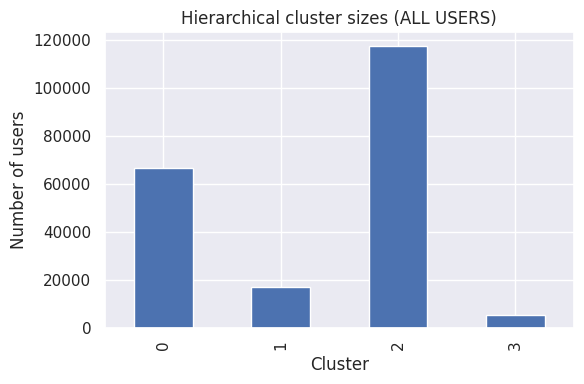

In [ ]:
# --- Quick cluster size plot ---

plt.figure(figsize=(6,4))
cluster_counts_all.plot(kind="bar")
plt.title("Hierarchical cluster sizes (ALL USERS)")
plt.xlabel("Cluster")
plt.ylabel("Number of users")
plt.tight_layout()
plt.show()
